In [ ]:
import cv2
from google.colab.patches import cv2_imshow


In [ ]:
def compr(name):
  img = cv2.imread(name, cv2.IMREAD_UNCHANGED)
  final_wide = 320
  r = float(final_wide) / img.shape[1]
  dim = (final_wide, int(img.shape[0] * r))

# уменьшаем изображение до подготовленных размеров
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  cv2_imshow(resized)
  print(resized.shape)
  return resized
  

пройдем по всем картинкам и присвоим им номер класса

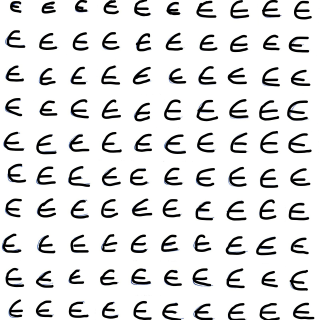

(320, 320, 3)


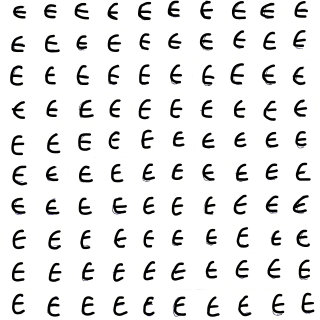

(320, 320, 3)


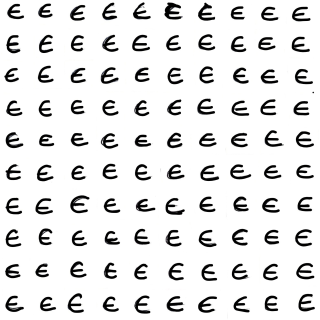

(320, 320, 3)


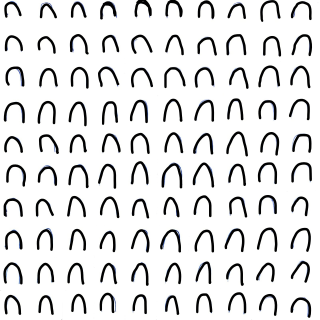

(320, 320, 3)


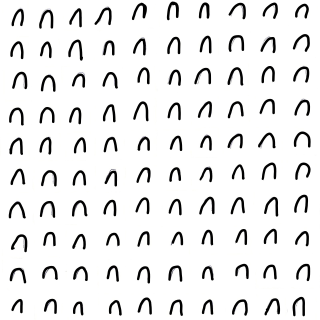

(320, 320, 3)


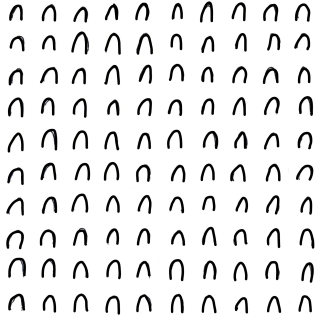

(320, 320, 3)


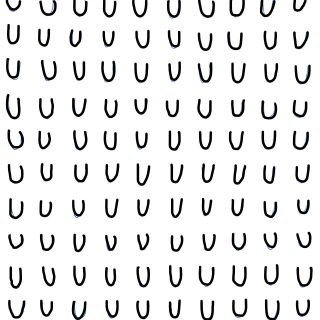

(320, 320, 3)


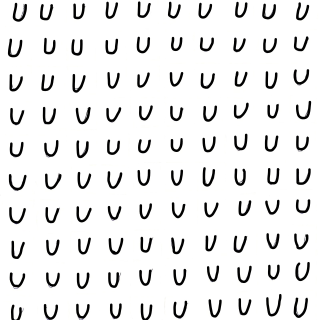

(320, 320, 3)


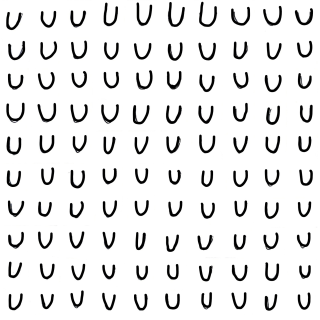

(320, 320, 3)


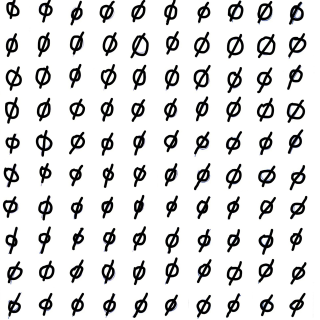

(320, 320, 3)


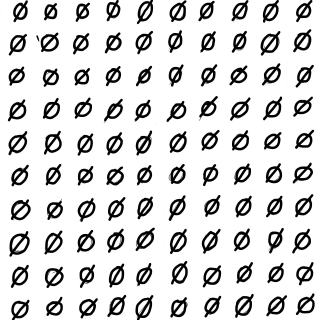

(320, 320, 3)


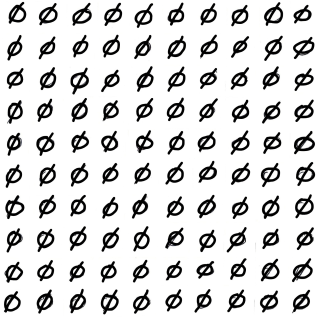

(320, 320, 3)


In [ ]:
pictures = ['/affiliation_1.jpg', '/affiliation_2.jpg','/affiliation_3.jpg', '/crossing_1.jpg', '/crossing_2.jpg', '/crossing_3.jpg', '/union_1.jpg', '/union_2.jpg', '/union_3.jpg', '/empty_1.jpg', '/empty_2.jpg', '/empty_3.jpg']
compressed_pictures = []
class_numbers = []
for i in range (3):
  compressed_pictures.append(compr(pictures[i]))
  class_numbers.append(0)
for j in range (3):
  compressed_pictures.append(compr(pictures[j + 3]))
  class_numbers.append(1)
for l in range (3):
  compressed_pictures.append(compr(pictures[l + 6]))
  class_numbers.append(2)
for i in range (3):
  compressed_pictures.append(compr(pictures[i + 9]))
  class_numbers.append(3)

С шагом в 32х32 вырежем все объекты для выборки из больших картинок

In [ ]:
def pars(objects, names, class_name, resized):
  for i in range(0, 320, 32):
    for j in range(0, 320, 32):
      cropped = resized[i: i + 32, j: j + 32]
      objects.append(cropped)
      names.append(class_name)



In [ ]:
ims = []
names = []
for i in range (len(class_numbers)):
  pars(ims, names, class_numbers[i], compressed_pictures[i])


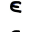

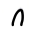

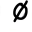

In [ ]:
cv2_imshow(ims[0])
cv2_imshow(ims[400])
cv2_imshow(ims[1000])


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

Нормируем наши данные и разобьем их на тестовую и тренировочную выборку

In [ ]:
from sklearn.model_selection import train_test_split

data = np.array(ims)
data = data / 255
labels = np.array(names)
data = data.reshape(1200, 32*32*3)


X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.15)



Создадим простейшую однослойную сеть и проверим ее работу на наших данных

In [ ]:
import tensorflow as tf



model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(4,activation='softmax',input_shape=(32*32*3,)))


model.compile(tf.keras.optimizers.Adam(0.1),'sparse_categorical_crossentropy',['accuracy'])
model.summary()
model.fit(X_train, y_train, validation_data=(X_test, y_test) ,batch_size=4,epochs=10)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 4)                 12292     
Total params: 12,292
Trainable params: 12,292
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
255/255 [==============================] - 1s 2ms/step - loss: 55.8863 - accuracy: 0.5147 - val_loss: 97.9317 - val_accuracy: 0.3889
Epoch 2/10
255/255 [==============================] - 0s 2ms/step - loss: 31.3722 - accuracy: 0.6833 - val_loss: 58.5520 - val_accuracy: 0.5611
Epoch 3/10
255/255 [==============================] - 0s 2ms/step - loss: 44.7296 - accuracy: 0.7020 - val_loss: 29.5061 - val_accuracy: 0.7111
Epoch 4/10
255/255 [==============================] - 0s 2ms/step - loss: 31.5878 - accuracy: 0.7657 - val_loss: 30.4306 - val_accuracy: 0.7500
Epoch 5/10
255/255 [==============================] - 0s 2ms/step -

Как видим средняя точность на тестовой выборке около 80% что не впечатляет. Теперь реализуем сверточную нейронную сеть. Она будет состоять из двух сверточных слоев размера 3х3 и одного maxpooling слоя размером 2х2. Также добавим 2 линейных слоя с активационными функциями relu и softmax. В качестве оптимизатора используем adam, в качестве функции ошибки sparse_categorical_crossentropy. 

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.constraints import maxnorm



model = tf.keras.models.Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

epochs = 3
lrate = 0.0005
decay = lrate/epochs
adam = tf.keras.optimizers.Adam(lr=lrate, decay=decay)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_28 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((ims, names))

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=4)

Epoch 1/3
255/255 [==============================] - 23s 87ms/step - loss: 0.7637 - accuracy: 0.7137 - val_loss: 0.0904 - val_accuracy: 0.9667
Epoch 2/3
255/255 [==============================] - 22s 87ms/step - loss: 0.0582 - accuracy: 0.9853 - val_loss: 0.0443 - val_accuracy: 0.9833
Epoch 3/3
255/255 [==============================] - 22s 87ms/step - loss: 0.0112 - accuracy: 0.9990 - val_loss: 0.0303 - val_accuracy: 0.9889


Как видим после первой же эпохи точность на валидационной выборке составила 96% и дальше выросла до 98%, что очень впечатляет.